# 1. Introduction
# ICU Survival Cox and Predictive Models

**Approach**  
Part 2 moves from description (KM Curve) to inference with the Cox proportional hazards model (CPH), and then to prediction with supervised classifiers at fixed horizons

**Learning goals**  
- Fit and interpret a Cox proportional hazards model in lifelines  
- Check the proportional hazards assumption and address violations  
- Translate hazard ratios into individualized survival curves  
- Build and evaluate predictive classifiers for in-hospital mortality and fixed horizons at 7, 30, and 60 days  
- Compare Cox risk with classifier probabilities using discrimination and calibration metrics  
- Avoid data leakage and ensure reproducible 70 percent, 20 percent, 10 percent splits

**Methods and data**  
- Data  
  • [PhysioNet Challenge 2012 dataset](https://physionet.org/content/challenge-2012/1.0.0/), Set A aggregate file  
  • We standardize to `duration_days` and `event_death` to keep Part 1 and Part 2 consistent  

- Software  
  • lifelines for Cox and diagnostics  
  • scikit-learn for preprocessing, classifiers, and calibration  
  • scikit-survival for time-dependent AUC and integrated Brier score  

**Key references**  
- PhysioNet Challenge 2012 overview and dataset  
  • https://physionet.org/challenge/2012/  
- lifelines CoxPHFitter and assumption checks  
  • https://lifelines.readthedocs.io/en/latest/fitters/regression/CoxPHFitter.html  
- scikit-learn documentation  
  • Pipeline and ColumnTransformer: https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html  
  • CalibrationDisplay: https://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibrationDisplay.html  
  • Brier score: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.brier_score_loss.html  
- scikit-survival time-dependent metrics  
  • cumulative_dynamic_auc: https://scikit-survival.readthedocs.io/en/stable/api/generated/sksurv.metrics.cumulative_dynamic_auc.html


# 2. Setup

In [ ]:
# Setup and reproducibility

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

import os
import sys
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

# Survival modeling
import lifelines
from lifelines import CoxPHFitter

# Scikit-learn core utilities
import sklearn
from sklearn import set_config
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler


# Modeling for later sections
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    brier_score_loss,
    RocCurveDisplay,
    PrecisionRecallDisplay
)
from sklearn.calibration import CalibrationDisplay
from sklearn.model_selection import train_test_split, StratifiedKFold
from sksurv.nonparametric import cumulative_incidence_competing_risks

# Persistence
import joblib

# Local helpers supplied with Part 1
import utils

# Optional scikit-survival for time-dependent metrics
SKSURV_AVAILABLE = False
try:
    from sksurv.metrics import cumulative_dynamic_auc, integrated_brier_score
    from sksurv.util import Surv
    SKSURV_AVAILABLE = True
except ImportError as e:
    print("scikit-survival not available. Time-dependent metrics will be skipped.")
    print(f"Import error: {e}")

# Global configuration
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Matplotlib defaults for simple, readable figures
plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams["axes.grid"] = True
plt.rcParams["font.size"] = 11

# Show library versions for reproducibility
def _get_ver(mod):
    return getattr(mod, "__version__", "n/a")

print("Versions")
print(f"python              : {sys.version.split()[0]}")
print(f"numpy               : {_get_ver(np)}")
print(f"pandas              : {_get_ver(pd)}")
print(f"lifelines           : {_get_ver(lifelines)}")
print(f"scikit-learn        : {_get_ver(sklearn)}")
print(f"scikit-survival     : {'available' if SKSURV_AVAILABLE else 'not available'}")

# Ensure consistent display
pd.set_option("display.max_columns", 100)
pd.set_option("display.width", 120)

Versions
python              : 3.11.13
numpy               : 2.3.3
pandas              : 2.3.3
lifelines           : 0.30.0
scikit-learn        : 1.7.2
scikit-survival     : available


# 3. Load data and define variables

### Predictor selection and leakage control

- We will use only variables that are known or measured at or near ICU admission (avoids hindsight bias and leakage)
- We will exclude any variable that is a direct consequence of the outcome or occurs late in the stay (post-outcome signals inflate accuracy)
- We will explicitly drop `Length_of_stay` and any outcome derived fields to avoid label leakage (leak outcome information into predictors)
- We will keep preprocessing simple and transparent to support clinical interpretability

In [2]:
# Data loading and survival field standardization
from IPython.display import display
import os

# --- 1. Load Data ---
PATH = "PhysionetChallenge2012-set-a.csv.gz"

# Simple check to ensure the data file exists before trying to load it
if not os.path.exists(PATH):
    raise FileNotFoundError(
        f"Error: The data file was not found at '{PATH}'. "
        "Please ensure the dataset is in the correct directory."
    )

ICU = pd.read_csv(PATH, compression="gzip")

# --- 2. Find and Standardize Survival Columns ---
# Prefer 'Survival' for duration, as it's the target in the Challenge documentation
duration_col = "Survival"
event_col = "In-hospital_death"

if duration_col not in ICU.columns or event_col not in ICU.columns:
    raise ValueError(f"Could not find required columns: '{duration_col}' or '{event_col}'")

# Create standardized fields for consistency across notebooks
ICU["duration_days"] = ICU[duration_col].astype(float)
ICU["event_death"] = ICU[event_col].astype(int)

# --- 3. Validate and Clean Data ---
# Keep only rows with valid survival data
ICU.dropna(subset=["duration_days", "event_death"], inplace=True)
ICU = ICU[ICU["event_death"].isin([0, 1])].copy() # Ensure event is 0 or 1

# A key step in survival analysis: time must be positive
non_positive_durations = ICU["duration_days"] <= 0
if non_positive_durations.any():
    print(f"Watch Out: Dropping {non_positive_durations.sum()} rows with non-positive survival time.")
    ICU = ICU[~non_positive_durations].copy()


# --- 4. Final Data Summary ---
print(f"Data successfully loaded and cleaned. Final dataset has {len(ICU)} rows.")

# Display a preview of key columns as a formatted table
print("\nPreview of standardized data:")
preview_cols = ["duration_days", "event_death", "Age", "Gender", "SAPS-I", "SOFA"]
preview_cols = [c for c in preview_cols if c in ICU.columns]
display(ICU[preview_cols].head())

# Display descriptive statistics for the survival variables
print("\nDescriptive statistics for survival variables:")
display(ICU[["duration_days", "event_death"]].describe())

# Display the final counts of events vs. censored cases
print("\nEvent and censoring counts:")
display(ICU["event_death"].value_counts().rename({0: "Censored (Discharged)", 1: "Event (Death)"}).to_frame("Count"))

Watch Out: Dropping 2529 rows with non-positive survival time.
Data successfully loaded and cleaned. Final dataset has 1471 rows.

Preview of standardized data:


,duration_days,event_death,Age,Gender,SAPS-I,SOFA
3,575.0,0,68.0,1.0,7,1
4,918.0,0,88.0,0.0,17,2
5,1637.0,0,64.0,1.0,14,11
7,5.0,1,78.0,0.0,19,8
8,38.0,0,64.0,0.0,11,0



Descriptive statistics for survival variables:


,duration_days,event_death
count,1471.000000,1471.000000
mean,351.779742,0.376615
std,530.225233,0.484702
min,1.000000,0.000000
25%,11.000000,0.000000
50%,70.000000,0.000000
75%,485.000000,1.000000
max,2600.000000,1.000000



Event and censoring counts:


,Count
event_death,
Censored (Discharged),917
Event (Death),554


## 3.1. Predictor curation and leakage control

Restricting predictors to admission-time variables to support real decisions and valid inference. We remove outcome proxies and identifiers to prevent label leakage and inflated accuracy e.g.

- Exclude duration, event, `Length_of_stay`, and any ID fields
- Prefer a small, clinically sensible shortlist of common variables
- Drop any remaining variables with more than 30% missingness
- Build a clean modeling frame with predictors plus `duration_days` and `event_death`

**Clinical considerations**
- Keeping features interpretable supports decisions making
- Removing downstream variables like `Length_of_stay` avoids inflated performance
- A simpler, curated feature set often leads to a more robust and generalizable model (than using hundreds of raw variables)

In [3]:
# --- 1. Define Columns to Exclude ---

# Define columns related to the outcome or that "leak" future information
leakage_cols = [
    "duration_days", "event_death", "Survival", "In-hospital_death", "Length_of_stay"
]

# Find columns that look like identifiers
id_cols = [col for col in ICU.columns if "id" in col.lower() or "record" in col.lower()]

# Combine all columns to be removed from the feature set
cols_to_exclude = leakage_cols + id_cols

# --- 2. Select Candidate Features ---

# Start with all columns and remove the ones we've identified for exclusion
candidate_features = [col for col in ICU.columns if col not in cols_to_exclude]

# For this course, we'll focus on a curated list of common, clinically relevant predictors
# This improves model interpretability and stability.
curated_shortlist = [
    "Age", "Gender", "SAPS-I", "SOFA", "Height", "Weight",
    "CCU", "CSRU", "SICU"
]

# Use only the curated features that are actually present in our dataset
X_candidates = [col for col in curated_shortlist if col in candidate_features]


# --- 3. Filter by Missingness ---

# Calculate the percentage of missing values for our candidate features
missing_rate = ICU[X_candidates].isna().mean().sort_values(ascending=False)

# Identify features where more than 30% of the data is missing
too_missing = missing_rate[missing_rate > 0.30].index.tolist()

# The final list of features is our candidate list, excluding the ones with too much missing data
X_features = [col for col in X_candidates if col not in too_missing]

# --- 4. Report and Create Final DataFrame ---

print("--- Predictor Selection Report ---")
print(f"Excluded for leakage/ID : {sorted(list(set(cols_to_exclude) & set(ICU.columns)))}")
print(f"Removed for >30% missing: {too_missing}")
print(f"Final selected predictors : {X_features}")
print("--------------------------------\n")

# Display the missingness rates as a formatted table
print("Missingness Rate of Candidate Features:")
display(missing_rate.to_frame("Missing Rate"))

# Create the final DataFrame for modeling
MODEL_DF = ICU[X_features + ["duration_days", "event_death"]].copy()

print("\nFinal DataFrame for Modeling:")
display(MODEL_DF.head())

--- Predictor Selection Report ---
Excluded for leakage/ID : ['In-hospital_death', 'Length_of_stay', 'NIDiasABP_first', 'NIDiasABP_highest', 'NIDiasABP_last', 'NIDiasABP_lowest', 'NIDiasABP_median', 'Survival', 'duration_days', 'event_death', 'recordid']
Removed for >30% missing: ['Height']
Final selected predictors : ['Age', 'Gender', 'SAPS-I', 'SOFA', 'Weight', 'CCU', 'CSRU', 'SICU']
--------------------------------

Missingness Rate of Candidate Features:


,Missing Rate
Height,0.507138
Weight,0.087016
Gender,0.001360
Age,0.000000
SAPS-I,0.000000
SOFA,0.000000
CCU,0.000000
CSRU,0.000000
SICU,0.000000



Final DataFrame for Modeling:


,Age,Gender,SAPS-I,SOFA,Weight,CCU,CSRU,SICU,duration_days,event_death
3,68.0,1.0,7,1,84.6,0,0,0,575.0,0
4,88.0,0.0,17,2,NaN,0,0,0,918.0,0
5,64.0,1.0,14,11,114.0,1,0,0,1637.0,0
7,78.0,0.0,19,8,48.4,0,0,0,5.0,1
8,64.0,0.0,11,0,60.7,0,0,0,38.0,0


## 3.2. Data splitting: train, validation, and test sets

To build a reliable model and evaluate it fairly, we split our data into three distinct sets:
- **Training Set (70%)**: The data we use to fit our models. The model learns the patterns from this set.
- **Validation Set (20%)**: Used to check the proportional hazards assumption and for preliminary performance assessment. It helps us diagnose the model without "contaminating" the final test set.
- **Test Set (10%)**: Held back until the very end. We use it only once to report the final, unbiased performance of our chosen model.

In [4]:
# --- 1. Define Features and Target ---
# Y contains the survival information (duration and event)
Y = MODEL_DF[["duration_days", "event_death"]]
# X contains only the predictor variables
X = MODEL_DF[X_features]

# --- 2. Create Train and "Holdout" (Validation + Test) Sets ---
# First, split into a large training set (70%) and a smaller holdout set (30%)
# We stratify by 'event_death' to ensure the death rate is similar in both sets
X_train, X_holdout, y_train, y_holdout = train_test_split(
    X, Y,
    train_size=0.70,
    random_state=RANDOM_STATE,
    stratify=Y["event_death"]
)

# --- 3. Split "Holdout" into Validation and Test Sets ---
# The holdout set is 30% of the total data. We split it into 2/3 for validation
# (20% of total) and 1/3 for testing (10% of total).
X_val, X_test, y_val, y_test = train_test_split(
    X_holdout, y_holdout,
    test_size=0.33, # (10% total) / (30% total) = 0.33
    random_state=RANDOM_STATE,
    stratify=y_holdout["event_death"]
)

# --- 4. Report the Splits ---
print("--- Data Splitting Report ---")
print(f"Training set   : {len(X_train)} rows ({len(X_train) / len(MODEL_DF):.0%})")
print(f"Validation set : {len(X_val)} rows ({len(X_val) / len(MODEL_DF):.0%})")
print(f"Test set       : {len(X_test)} rows ({len(X_test) / len(MODEL_DF):.0%})")

# To prepare for lifelines, combine X and y back into single dataframes for each set
train_df = pd.concat([X_train, y_train], axis=1)
val_df = pd.concat([X_val, y_val], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)

--- Data Splitting Report ---
Training set   : 1029 rows (70%)
Validation set : 296 rows (20%)
Test set       : 146 rows (10%)


# 4. Cox proportional hazards: univariable model

We start with a single, clinically meaningful covariate (feature, predictor) to build our intuition about the Cox model. We will use **Age** to estimate its effect on the risk of death.

To ensure we handle data correctly and prevent any information leakage from our validation or test sets, we will use a **`scikit-learn` Pipeline**. (Even for this simple, one-variable case)

**Steps**
- Build a simple pipeline containing a `SimpleImputer`.
- **Fit** the pipeline using data from the **training set only**.
- **Transform** the training data to create our feature.
- Fit the `CoxPHFitter` and interpret the resulting Hazard Ratio (HR).

In [5]:
# Safety check to ensure 'Age' is available
if "Age" not in train_df.columns:
    raise ValueError("The 'Age' column is not in the training data.")

# --- 1. Define and Fit the Preprocessing Pipeline ---
# We create a pipeline to handle missing values for 'Age'.
# This ensures that we learn the median from the training set ONLY.
age_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))
])

# Fit the pipeline on the training data
age_pipeline.fit(train_df[['Age']])


# --- 2. Prepare the Data for the Cox Model ---
# Transform the 'Age' column using our fitted pipeline
age_imputed = age_pipeline.transform(train_df[['Age']])

# Create the final DataFrame for the lifelines model
univariable_df = pd.DataFrame({
    'Age': age_imputed.ravel(), # .ravel() flattens the array
    'duration_days': train_df['duration_days'],
    'event_death': train_df['event_death']
}, index=train_df.index)


# --- 3. Fit the Univariable Cox Model ---
cph_uni = CoxPHFitter(penalizer=0.01) # Small penalizer for stability
cph_uni.fit(univariable_df, duration_col="duration_days", event_col="event_death")

print("--- Univariable Cox Model Summary (Age) ---")
cph_uni.print_summary(
    decimals=3,
    columns=["coef", "exp(coef)", "exp(coef) lower 95%", "exp(coef) upper 95%", "p"]
)


# --- 4. Interpret the Hazard Ratio and Model Fit ---

# Extract results directly from the fitted model summary
summary_stats = cph_uni.summary.loc["Age"]
hr_1yr = summary_stats["exp(coef)"]
ci_lower = summary_stats["exp(coef) lower 95%"]
ci_upper = summary_stats["exp(coef) upper 95%"]
p_value = summary_stats["p"]

# Calculate the 10-year effect and its approximate confidence interval
hr_10yr = hr_1yr ** 10
ci_10yr_lower = ci_lower ** 10
ci_10yr_upper = ci_upper ** 10

# Get the concordance index (a measure of discriminative power)
c_index = cph_uni.concordance_index_

print("--- Hazard Ratio Interpretation ---")
print(f"Per 1-year increase in Age : HR = {hr_1yr:.3f} (95% CI: {ci_lower:.3f} to {ci_upper:.3f}), p = {p_value:.4f}")
print(f"Per 10-year increase in Age: HR ≈ {hr_10yr:.3f} (Approx. 95% CI: {ci_10yr_lower:.3f} to {ci_10yr_upper:.3f})")
print(f"\nModel Concordance Index on Training Data: {c_index:.3f}")

--- Univariable Cox Model Summary (Age) ---


<lifelines.CoxPHFitter: fitted with 1029 total observations, 641 right-censored observations>
             duration col = 'duration_days'
                event col = 'event_death'
                penalizer = 0.01
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 1029
number of events observed = 388
   partial log-likelihood = -2596.328
         time fit was run = 2025-10-08 22:07:52 UTC

---
            coef exp(coef) exp(coef) lower 95% exp(coef) upper 95%     p
covariate                                                               
Age       -0.008     0.992               0.986               0.999 0.020
---
Concordance = 0.518
Partial AIC = 5194.655
log-likelihood ratio test = 5.229 on 1 df
-log2(p) of ll-ratio test = 5.492

--- Hazard Ratio Interpretation ---
Per 1-year increase in Age : HR = 0.992 (95% CI: 0.986 to 0.999), p = 0.0204
Per 10-year increase in Age: HR ≈ 0.924 (Approx. 95% CI: 0.865 to 0.988)

Model Concordance Index on Training Data: 0.518


### Clinical Insight: Interpreting preliminaty results

* **The Hazard Ratio (HR)**
    The model shows an HR for Age of **0.992** (p=0.020). Suggesting that each additional year of age is associated with a slight *decrease* (0.8%) in the instantaneous risk of death (However, not significant)

* **The Concordance Index (C-index) is Weak**
    The C-index is **0.518**, is only marginally better than a random coin toss (0.500). This confirms that Age by itself has very poor power to correctly rank patients by their individual risk

* **The Finding Points to Confounding**
    This result, combined with the weak C-index, is a clear sign of **confounding**. It tells us that looking at Age in isolation is highly misleading. Other factors, like patient illness severity, are much stronger drivers of the outcome

## 4.1 A Quick Sensitivity Check for Competing Risks

Before building our main model, we will do a sanity check to see if being discharged from the hospital could bias the effect of `Age`. We will plot the cumulative incidence of in-hospital death for different age groups, which correctly accounts for discharge as a "competing event."

**What we are looking for**
* If the curves are non-clearly separated by age, it supports the idea that the effect of `Age` is not consistent
* If the curves cross or behave unexpectedly, it suggests confounding

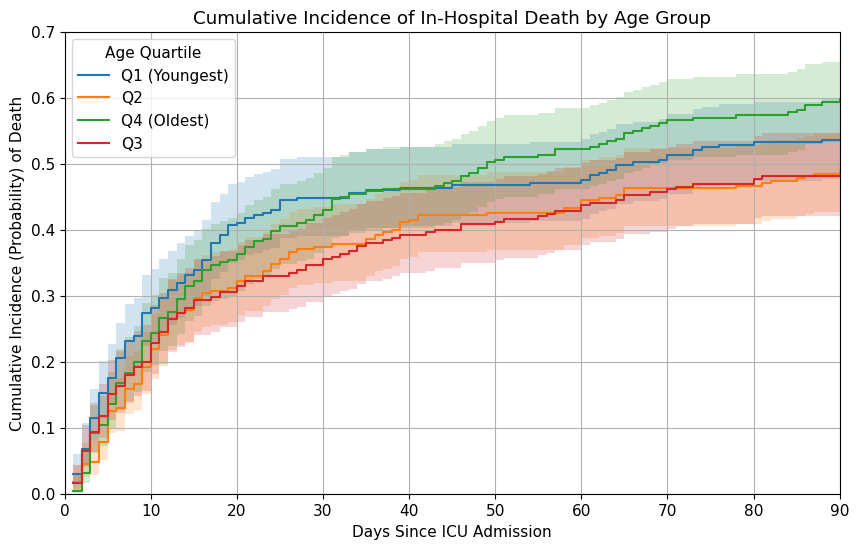

In [6]:
# --- 1. Prepare Data for the Plot ---
# We use data from the training set only for this check.
# Event coding: 1 = death (event of interest), 2 = discharge (competing event)
event_type_train = np.where(train_df["event_death"] == 1, 1, 2)
time_train = train_df["duration_days"]
age_series = train_df["Age"]

# Create Age Bands (quartiles) for plotting
# The try/except block makes our code robust if quartiles can't be calculated
try:
    age_band = pd.qcut(age_series, q=4, labels=["Q1 (Youngest)", "Q2", "Q3", "Q4 (Oldest)"])
except Exception:
    edges = [age_series.min(), 50, 70, 85, age_series.max()]
    age_band = pd.cut(age_series, bins=edges, include_lowest=True)

# --- 2. Calculate and Plot the Cumulative Incidence ---
fig, ax = plt.subplots(figsize=(10, 6))

for label in age_band.unique():
    idx = (age_band == label)
    
    # Estimate CIF with pointwise confidence intervals
    time_points, cif, conf_int = cumulative_incidence_competing_risks(
        event=event_type_train[idx],
        time_exit=time_train[idx],
        conf_type="log-log"
    )
    
    # With our coding, the first row (index 0) of the output is for event 1 (death)
    ax.step(time_points, cif[0], where="post", label=label)
    ax.fill_between(time_points, conf_int[0, 0], conf_int[0, 1], step="post", alpha=0.2)

ax.set_title("Cumulative Incidence of In-Hospital Death by Age Group")
ax.set_xlabel("Days Since ICU Admission")
ax.set_ylabel("Cumulative Incidence (Probability) of Death")
ax.set_xlim(0, 90)
ax.set_ylim(0, 0.7)
ax.legend(title="Age Quartile")
ax.grid(True)
plt.show()

### Clinical Conclusions from the CIF Plot

* Confidence intervals for all age groups overlap substantially, showing no clear statistical difference
* The youngest group (**Q1, blue**) initially shows a higher absolute risk than the oldest (**Q4, green**)
* This crossing pattern suggests the effect of age is complex and changes over time
* The surprising early risk in the youngest group strongly suggests confounding by patient illness severity
* A simple interpretation of age is not possible; a multivariable model is essential

# 5. Multivariable Cox Proportional Hazards Model

Our previous analyses proved that looking at one variable at a time is misleading due to confounding. The solution is to build a **multivariable model**, which estimates the effect of each predictor while simultaneously controlling for the effects of all others.

We will use the preprocessing pipeline we defined in the previous step to ensure our data is clean and consistently formatted.

**What we do next**
* Combine our preprocessed features (`X_train_tr`) with the outcome data (`y_train`).
* Fit the `CoxPHFitter` model on this complete, preprocessed training dataset.
* Evaluate the model's performance by checking its concordance on both the training and validation sets.

In [ ]:
# 5. Multivariable Cox proportional hazards model

# Safety checks
for name in ["X_train", "X_val", "y_train", "y_val"]:
    if name not in globals():
        raise NameError(f"{name} not defined. Ensure section 3.2 ran successfully")

# 1) Detect feature types and build preprocessor with utils
numeric_cols, categorical_cols = utils.detect_feature_types(X_train)
cox_preprocessor = utils.build_preprocessor(
    numeric_cols=numeric_cols,
    categorical_cols=categorical_cols,
    num_strategy="median",
    cat_strategy="most_frequent"
)

# 2) Fit on TRAIN ONLY and transform splits
cox_preprocessor.fit(X_train)
X_train_cox = utils.to_dataframe(cox_preprocessor, X_train)
X_val_cox   = utils.to_dataframe(cox_preprocessor, X_val)

# 3) Build modeling frames for lifelines
train_cox_df = pd.concat([X_train_cox, y_train[["duration_days", "event_death"]]], axis=1)
val_cox_df   = pd.concat([X_val_cox,   y_val[["duration_days", "event_death"]]],   axis=1)

# 4) Fit Cox PH with Efron ties and a small L2 penalizer for stability
cph_multi = CoxPHFitter(penalizer=0.01)
cph_multi.fit(train_cox_df, duration_col="duration_days", event_col="event_death")

print("--- Multivariable Cox model summary ---")
cph_multi.print_summary(
    decimals=3,
    columns=["coef", "exp(coef)", "exp(coef) lower 95%", "exp(coef) upper 95%", "p"]
)

# 5) Concordance baseline
cindex_train = float(cph_multi.concordance_index_)
cindex_val = float(cph_multi.score(val_cox_df, scoring_method="concordance_index"))
print(f"\nConcordance | train {cindex_train:.3f} | validation {cindex_val:.3f}")

# Keep objects for next steps
cox_feature_names = X_train_cox.columns.tolist()


--- Multivariable Cox model summary ---


<lifelines.CoxPHFitter: fitted with 1029 total observations, 641 right-censored observations>
             duration col = 'duration_days'
                event col = 'event_death'
                penalizer = 0.01
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 1029
number of events observed = 388
   partial log-likelihood = -2556.611
         time fit was run = 2025-10-08 22:08:51 UTC

---
              coef exp(coef) exp(coef) lower 95% exp(coef) upper 95%       p
covariate                                                                   
num__Age    -0.007     0.994               0.987               1.000   0.066
num__Gender -0.083     0.920               0.750               1.129   0.425
num__SAPS-I  0.010     1.010               0.990               1.031   0.334
num__SOFA    0.085     1.088               1.057               1.120 <0.0005
num__Weight -0.002     0.998               0.993               1.002   0.300
num__CCU    -0.124     0.883               0.658               1.185   0.409
num__CSRU   -0.867     0.420               0.294               0.600 <0.0005
num__SICU    0.124     1.132               0.893               1.434   0.306
---
Concordance = 0.634
Partial AIC = 5129.222
log-likelihood ratio test = 84.662 on 8 df
-log2(p) of ll-ratio test = 47.342


Concordance | train 0.634 | validation 0.659


### Multivariable Cox Model: Final Interpretation

This model untangles the independent effect of each admission-time factor after accounting for all others. Here is the definitive interpretation of the results.

---
#### What the Model Says

* **Overall fit is moderate** with a validation concordance of **0.659**
* **SOFA score is the dominant driver** of risk (**HR 1.088**, p < 0.001)
    * A clinically meaningful 5-point increase in SOFA implies a **~52% higher risk** (HR ≈ 1.52)
* **Age is near-neutral after adjustment** and not statistically significant (**HR 0.994**, p = 0.066)
* **The CSRU unit shows a strong protective effect** (**HR 0.420**, p < 0.001) vs the reference medical ICU
* **SAPS-I's effect is smaller** when SOFA is included, as they measure similar aspects of patient acuity
* **Gender, Weight, CCU, and SICU** are not statistically significant in this model

---
#### Clinical Takeaways

* **Use SOFA for risk stratification** as it's the strongest indicator of a patient's risk
* **Treat the effect of age as complex** and non-linear, not a simple per-year risk factor
* **Adjust for ICU type in comparisons**, as baseline risk is very different across units like the CSRU
* **Performance is reasonable but can be improved** with richer features or more flexible modeling terms

## 5.1. Proportional Hazards Assumption Check

The model's main assumption is that the effect of each variable (its Hazard Ratio) is **constant over time**. e.g. it assumes the risk from a high `SOFA` score is the same on Day 2 as it is on Day 20. We test to ensure our conclusions are reliable.

We use a built-in `lifelines` function that performs a statistical test for each variable and plots the "Schoenfeld residuals" for any that might violate the assumption.

**What we are looking for**
* **Statistical Test**: A p-value greater than 0.05 for a variable suggests it meets the assumption
* **Residual Plot**: The plot should look like random noise with no obvious trend. A clear slope or pattern in the plot is a red flag that the variable's effect changes over time


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...

Proportional hazard assumption looks okay.

Covariates to scrutinize first: ['num__Age', 'num__SOFA', 'num__CCU', 'num__CSRU', 'num__SICU']


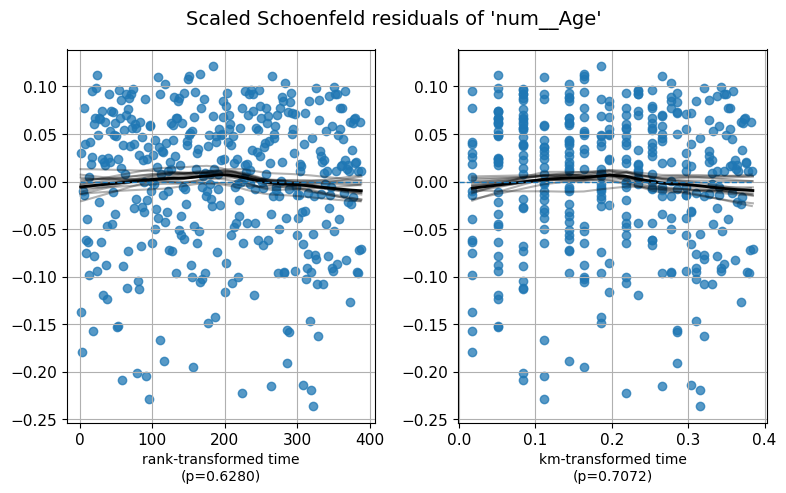

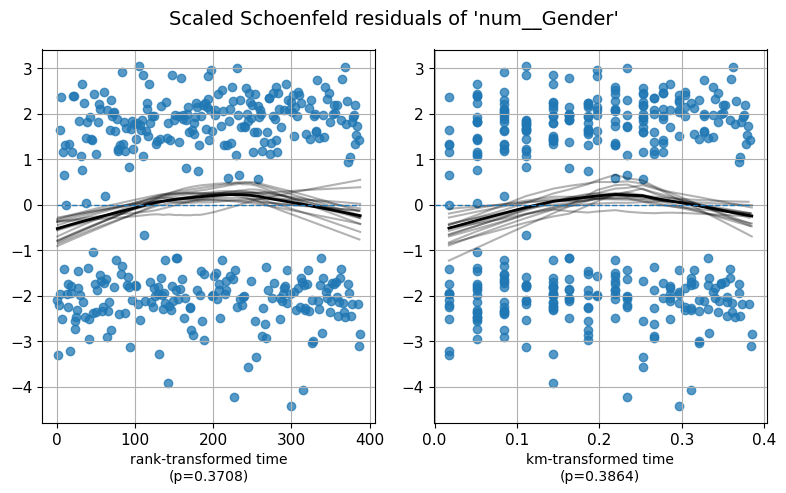

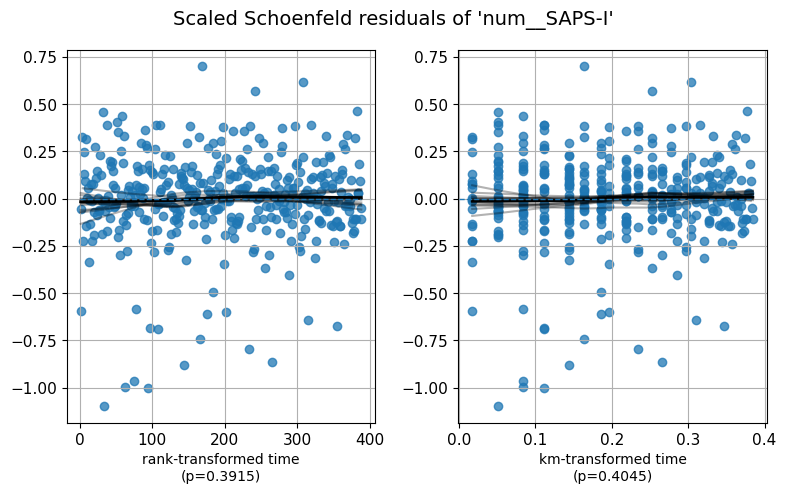

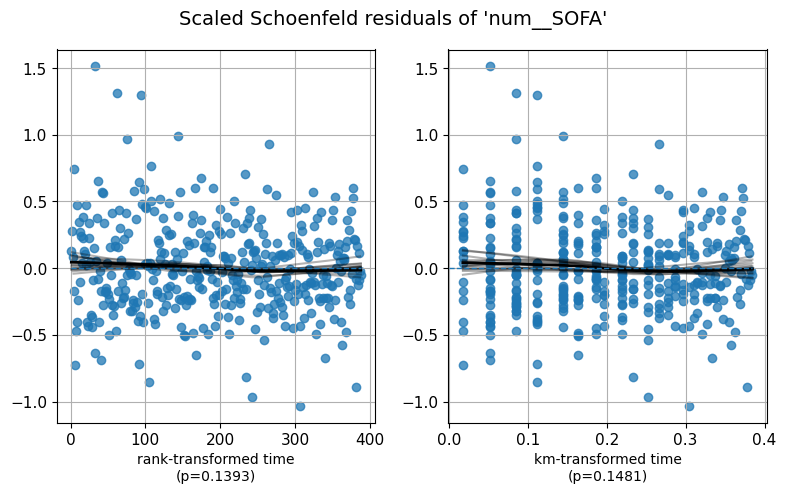

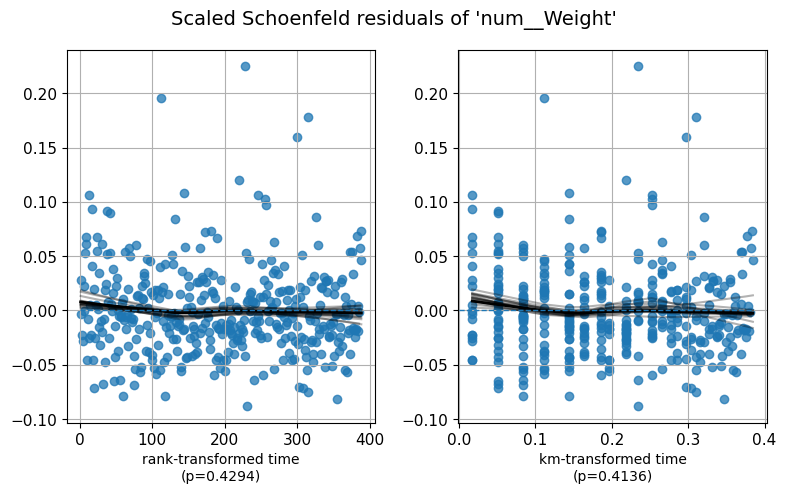

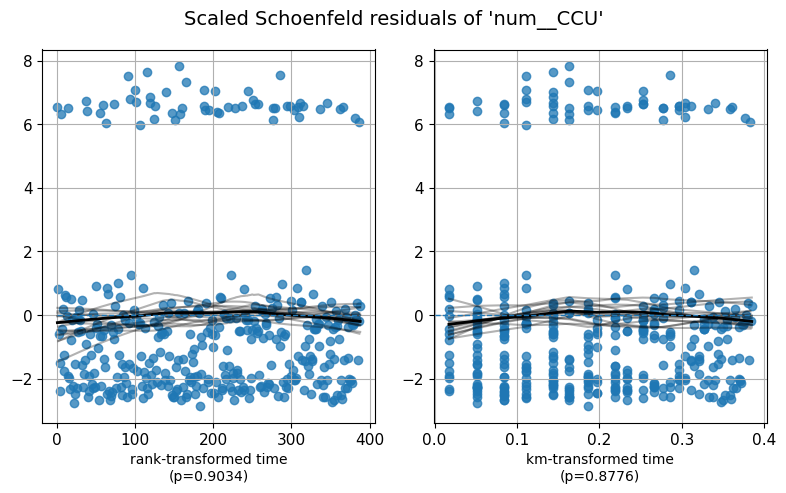

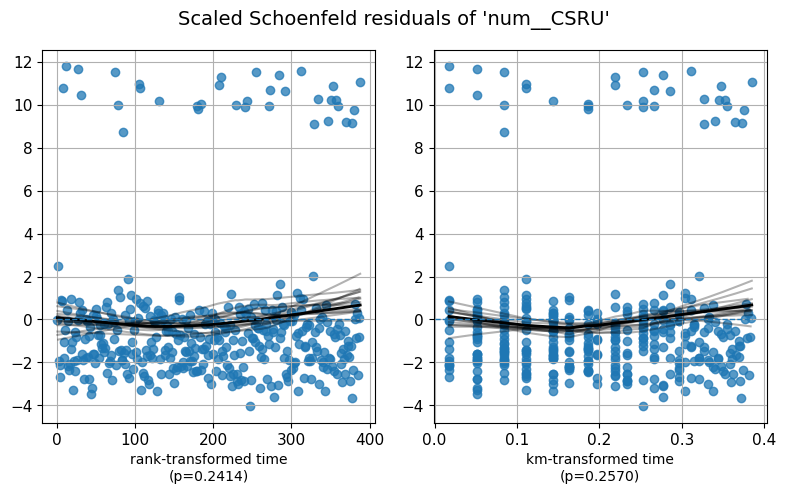

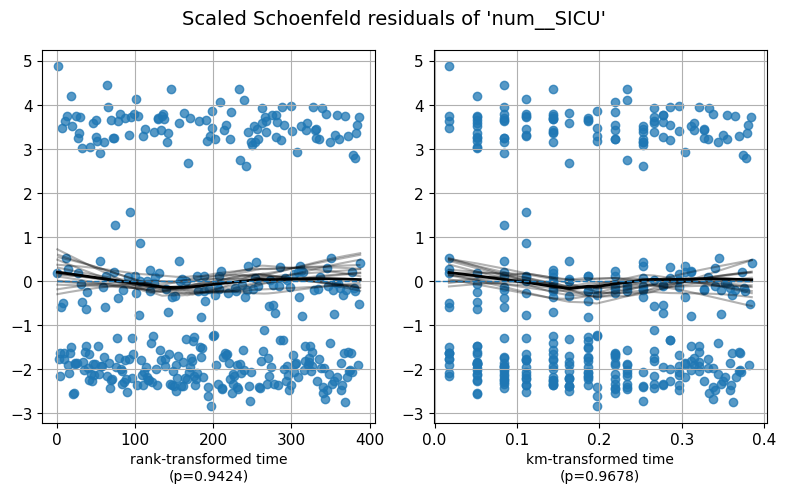

In [ ]:
# --- 1. Run the Proportional Hazards Assumption Check ---
# We use the fitted multivariable model (cph_multi) and the processed training data
# The function will automatically flag any variables that fail the test (p < 0.05)

cph_multi.check_assumptions(
    training_df=train_cox_df,
    p_value_threshold=0.05,
    show_plots=True
)

# 2) Convenience: print the covariate names that might be most at risk of non-PH
suspect_terms = [c for c in train_cox_df.columns if any(k in c.lower() for k in ["sofa", "ccu", "csru", "sicu", "age"])]
print("\nCovariates to scrutinize first:", suspect_terms)


### What to Do if the Assumption Fails?

If a variable fails the PH test, it does not mean the model is useless, but it means we need a more advanced technique to model that variable correctly.

* **Common Remedies**
    If a key variable (like `SOFA` or an ICU type) fails the test:
    1.  **Stratification**: We can stratify the model by that variable (e.g., `strata=['ICUType']`). This allows each stratum (each ICU type) to have its own unique baseline hazard, relaxing the PH assumption
    2.  **Time-Varying Covariates**: For a continuous variable like `SOFA`, we could include an interaction term with time (e.g., `SOFA * log(time)`)

## 5.2 Forest Plot: Visualizing the Model's Results

The summary table gives us the precise numbers, but a **forest plot** helps us see the results at a glance. It's a standard way to visualize the output of a regression model.

How to Read the Forest Plot
- Each variable from our model is on the y-axis
- The x-axis shows the **Hazard Ratio (HR)**
- The dot represents the HR for that variable
- The horizontal line through the dot is the **95% confidence interval**
- The vertical dashed line is at HR = 1.0 (no effect)
- If a variable's confidence interval (the horizontal line) does **not** cross the vertical "no effect" line, it is statistically significant

--- Forest Plot of Multivariable Cox Model ---


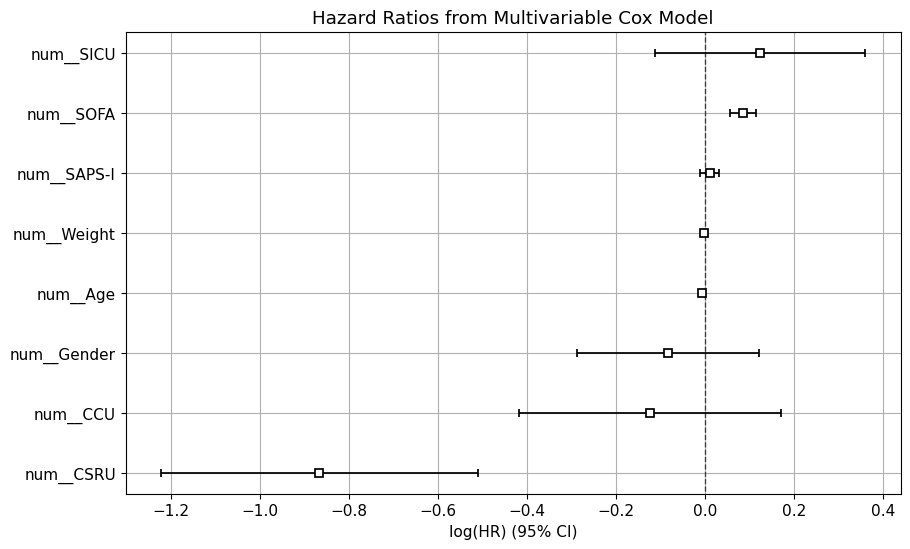

In [13]:
# The lifelines library has a convenient built-in function to create a forest plot.
# This is much simpler than building it manually.

print("--- Forest Plot of Multivariable Cox Model ---")
fig, ax = plt.subplots(figsize=(10, 6))

cph_multi.plot(ax=ax)

ax.set_title("Hazard Ratios from Multivariable Cox Model")
plt.show()

**Clinical insight from the forest plot**

- SOFA is clearly associated with higher instantaneous risk HR ≈ 1.09 per point with a narrow CI entirely above 1  
    - Clinically, a 5 point increase implies HR ≈ 1.5
- CSRU shows a strong protective association vs the reference ICU HR ≈ 0.42 with a CI entirely below 1  
    - Likely reflects different case mix and perioperative pathways
- Age, SAPS-I, Gender, Weight, CCU, SICU have CIs that cross 1 so they are not statistically significant in this multivariable model
- The x axis is on the log(HR) scale for plotting convenience interpret effects on the HR scale exp(coef)
- Use these effects for explanation and triage guidance not absolute risk

# 6. Individualized Prediction and Risk Separation

Now we shift our focus from **explanation** to **prediction**.

We will answer two key questions:
1.  Can the model successfully separate (discriminate) patients into different risk groups?
2.  What does a personalized risk prediction look like for an individual patient?

## 6.1 Risk Stratification on the Test Set

1. We'll assign a risk score to each patient in the test set
2. We'll divide them into four risk groups (quartiles) and plot their survival using a Kaplan-Meier curve

If the model is good, the curves for the high-risk groups should be clearly separated from and lower than the curves for the low-risk groups

**Crucial Step**: The risk score boundaries (the quartiles) are learned from the **training set only** to avoid any data leakage

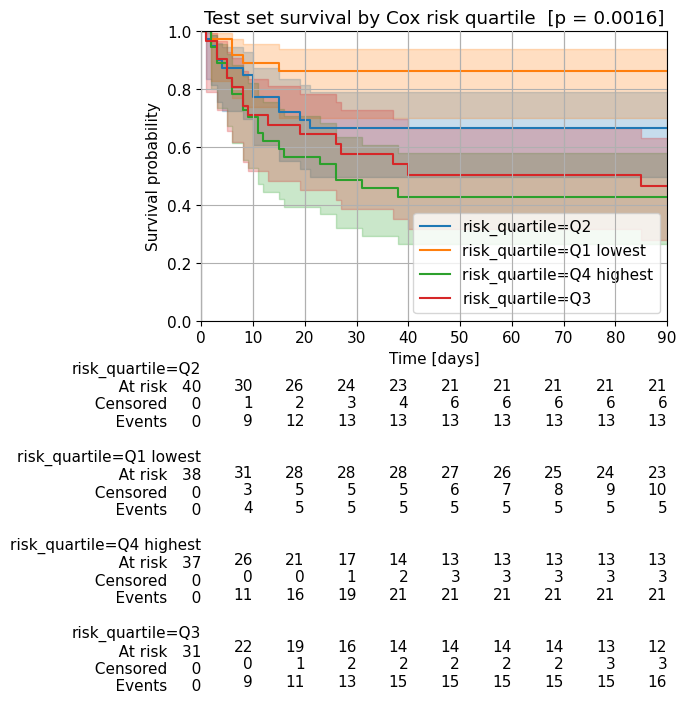

In [25]:
# 1) Transform TEST features with the training-fitted preprocessor
X_test_cox  = utils.to_dataframe(cox_preprocessor, X_test)
X_train_cox = utils.to_dataframe(cox_preprocessor, X_train)  # for risk cut points

# 2) Compute partial hazards (risk scores)
risk_train = np.asarray(cph_multi.predict_partial_hazard(X_train_cox)).ravel()
risk_test  = np.asarray(cph_multi.predict_partial_hazard(X_test_cox)).ravel()

# Quartile cut points learned on TRAIN ONLY
q1, q2, q3 = np.quantile(risk_train, [0.25, 0.50, 0.75])
bins = [-np.inf, q1, q2, q3, np.inf]
labels = ["Q1 lowest", "Q2", "Q3", "Q4 highest"]

test_groups = pd.cut(risk_test, bins=bins, labels=labels, include_lowest=True)

# 3) KM separation by risk quartile on TEST
test_eval_df = pd.concat(
    [y_test[["duration_days", "event_death"]].copy(),
     pd.Series(test_groups, index=X_test_cox.index, name="risk_quartile")],
    axis=1
)

fig, ax, logrank = utils.km_by_group(
    df=test_eval_df.rename(columns={"duration_days": "duration", "event_death": "event"}),
    group_col="risk_quartile",
    time_col="duration",
    event_col="event",
    xmax=90,
    title="Test set survival by Cox risk quartile",
    show_table=True
)
plt.show()

#### 6.2 Personalized Survival Predictions

Beyond grouping patients, the Cox model can generate a specific survival probability curve for each individual patient. Let's find the lowest-risk and highest-risk patients in our test set and see what the model predicts for them.

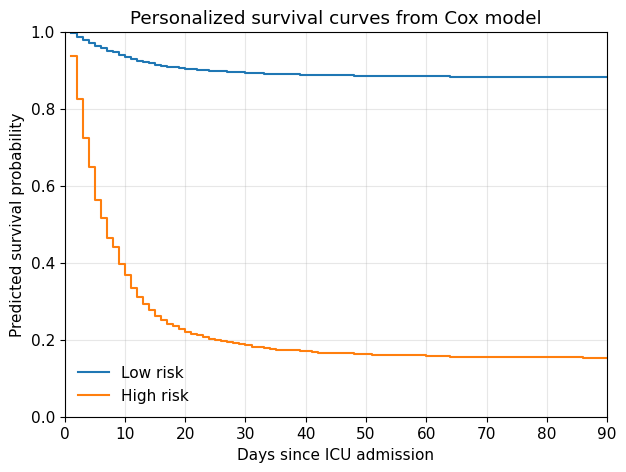

In [24]:
# 4) Two example survival curves low vs high risk (from TEST)
low_idx  = X_test_cox.index[np.argmin(risk_test)]
high_idx = X_test_cox.index[np.argmax(risk_test)]

sf_df = cph_multi.predict_survival_function(X_test_cox.loc[[low_idx, high_idx]])
# lifelines returns times as index, patients as columns
plt.figure(figsize=(7, 5))
for col, label in zip(sf_df.columns, ["Low risk", "High risk"]):
    plt.step(sf_df.index, sf_df[col], where="post", label=label)
plt.xlim(0, 90)
plt.ylim(0, 1)
plt.xlabel("Days since ICU admission")
plt.ylabel("Predicted survival probability")
plt.title("Personalized survival curves from Cox model")
plt.legend(frameon=False)
plt.grid(alpha=0.3)
plt.show()

### 6.3

In [27]:
# Recompute time-dependent AUC and Brier scores at 7, 30, 60 days correctly

from sksurv.util import Surv
from sksurv.metrics import cumulative_dynamic_auc, brier_score

# 1) Choose evaluable horizons within the observed follow-up
requested = np.array([7.0, 30.0, 60.0], dtype=float)
t_min_ev = float(y_test.loc[y_test["event_death"] == 1, "duration_days"].min())
t_max = float(y_test["duration_days"].max())
eval_times = requested[(requested > max(0.0, t_min_ev)) & (requested < t_max)]
if eval_times.size == 0:
    eval_times = requested  # fall back but still try to evaluate

# 2) Build structured outcomes
y_train_surv = Surv.from_arrays(
    event=y_train["event_death"].astype(bool).to_numpy(),
    time=y_train["duration_days"].to_numpy(dtype=float)
)
y_test_surv = Surv.from_arrays(
    event=y_test["event_death"].astype(bool).to_numpy(),
    time=y_test["duration_days"].to_numpy(dtype=float)
)

# 3) Time dependent AUC using Cox risk scores
auc_out = cumulative_dynamic_auc(y_train_surv, y_test_surv, risk_test, eval_times)
if isinstance(auc_out, tuple) and len(auc_out) == 2:
    auc_times, aucs = auc_out
else:
    auc_times, aucs = eval_times, np.atleast_1d(auc_out)

print("Time dependent AUCs:")
for t, a in zip(np.atleast_1d(auc_times), np.atleast_1d(aucs)):
    print(f"  {int(round(float(t)))} d -> {float(a):.3f}")

# 4) Brier scores using predicted survival probabilities at the same horizons
sf_times = cph_multi.predict_survival_function(X_test_cox, times=eval_times)
surv_matrix = sf_times.T.to_numpy()  # shape: n_test x n_times

bs_out = brier_score(y_train_surv, y_test_surv, surv_matrix, eval_times)
# Handle versions that return (scores, integrated) vs (times, scores)
if isinstance(bs_out, tuple):
    a, b = bs_out
    if np.allclose(np.atleast_1d(a), eval_times):
        brier_vals = np.atleast_1d(b)
    else:
        brier_vals = np.atleast_1d(a)
else:
    brier_vals = np.atleast_1d(bs_out)

print("Brier scores:")
for t, b in zip(eval_times, brier_vals):
    print(f"  {int(round(float(t)))} d -> {float(b):.3f}")


Time dependent AUCs:
  1 d -> 0.664
Brier scores:
  7 d -> 0.124
  30 d -> 0.202
  60 d -> 0.203
